In [1]:
import mo_descriptor as md
import nn_frame as nn
import numpy as np
import subprocess
subprocess.run('export TF_INTRA_OP_PARALLELISM_THREADS=12', shell=True)

2022-12-23 16:40:28.283221: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-23 16:40:28.283359: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


CompletedProcess(args='export TF_INTRA_OP_PARALLELISM_THREADS=12', returncode=0)

In [4]:
'''
prepare data_set
1. make mo_pair descriptor
'''
# x_shift = np.arange(0, 4.1, 0.1)
# y_shift = np.arange(0, 4.1, 0.1)
# z_shift = np.arange(3, 7.1, 0.1)
# lumo = md.MO_descriptor('data/lumo-s0.cube').make()
# homo = md.MO_descriptor('data/homo-s0.cube').make()

# # for the original pair of one mo and itself
# homo_pair = md.MO_pair_descriptor(homo, homo).make()
# lumo_pair = md.MO_pair_descriptor(lumo, lumo).make()

# homo_pairs = np.zeros((len(x_shift)*len(y_shift)*len(z_shift),) + homo_pair.shape)
# lumo_pairs = np.zeros((len(x_shift)*len(y_shift)*len(z_shift),) + lumo_pair.shape)

# homo_ = np.zeros(homo.shape)
# lumo_ = np.zeros(lumo.shape)

# for kk, k in enumerate(z_shift):
#     for ii, i in enumerate(x_shift):
#         for jj, j in enumerate(y_shift):
#             idx = kk * len(x_shift) * len(y_shift) + ii * len(y_shift) + jj
#             homo_[:,0] = np.add(homo[:,0],0)
#             homo_[:,1] = np.add(homo[:,1],i)
#             homo_[:,2] = np.add(homo[:,2],j)
#             homo_[:,3] = np.add(homo[:,3],k)

#             homo_pair_ = md.MO_pair_descriptor(homo, homo_).make()
#             homo_pairs[idx] = homo_pair_

#             lumo_[:,0] = np.add(lumo[:,0],0)
#             lumo_[:,1] = np.add(lumo[:,1],i)
#             lumo_[:,2] = np.add(lumo[:,2],j)
#             lumo_[:,3] = np.add(lumo[:,3],k)

#             lumo_pair_ = md.MO_pair_descriptor(lumo, lumo_).make()
#             lumo_pairs[idx] = lumo_pair_
        
# np.save('homo_homo_pair.npy', homo_pairs)
# np.save('lumo_lumo_pair.npy', lumo_pairs)
homo_pairs = np.load('./data/homo_homo_pair.npy')
lumo_pairs = np.load('./data/lumo_lumo_pair.npy')

In [6]:
'''
2. read coupling
'''
raw_data = np.loadtxt('../ML_Coupling/results.csv', delimiter=',',comments='#')
# c_homo = np.add(raw_data[:,2], raw_data[:,3]) * 1/2
# c_lumo = np.add(raw_data[:,4], raw_data[:,5]) * 1/2
c_homo = abs(raw_data[:,3])
c_lumo = abs(raw_data[:,4])

In [7]:
izero = []
for ii,i in enumerate(c_homo):
    if i<=0.0000:
        izero.append(ii)
        c_homo[ii] = 1e-9
print(len(izero))
homo_pairs = np.delete(homo_pairs, izero, 0)
c_homo = np.delete(c_homo, izero, 0)

izero = []
for ii,i in enumerate(c_lumo):
    if i<=0.0000:
        izero.append(ii)
        c_lumo[ii] = 1e-8
print(len(izero))


1154
1140


In [8]:
# x1 = homo_pairs[:,0,:,:]
# x2 = homo_pairs[:,1,:,:]
# x3 = homo_pairs[:,2,:,:]
# x4 = homo_pairs[:,3,:,:]
# x = np.einsum('aij,aij,aij,aij->aij', x1, x2, x3, x4)

train_homo_pairs = homo_pairs[:]
train_lumo_pairs = lumo_pairs

train_c_homo = -np.log(c_homo)[:]
train_c_lumo = -np.log(c_lumo)

test_homo_pairs = homo_pairs[1200:]
test_lumo_pairs = lumo_pairs[1200:]

test_c_homo = c_homo[1200:].reshape((len(c_homo[1200:]),1))
test_c_lumo = c_lumo[1200:]

In [12]:
import copy
train_homo = copy.deepcopy(train_homo_pairs)
train_chomo = copy.deepcopy(train_c_homo)
print(len(train_chomo))
index = np.random.choice(len(train_c_homo), size=int(len(train_c_homo)*0.1), replace=False)
train_homo_ = np.delete(train_homo,index,0)
train_chomo_ = np.delete(train_chomo,index,0)
print(len(train_homo_))

67767
60991


In [13]:
iall = np.arange(len(train_c_homo))
idiff = np.setdiff1d(iall,index)
test_homo = np.delete(copy.deepcopy(train_homo_pairs),idiff,0)
test_chomo = np.delete(copy.deepcopy(train_chomo),idiff,0)

In [9]:
setting = {'activation':'tanh', 'nn_shape':(256,256,256), 'batch_size':len(train_homo_), 'training_steps':200000,\
'learning_rate': 0.00008, 'decay_rate':0.95, 'decay_per_steps':1000, 'save_step':1000, 'drop_rate':0, 'save_path':'./save',\
'seed':None, 'debug_traj':False}
NN = nn.NN(setting_dict=setting)
NN.train(train_homo_,train_chomo_)

2022-12-10 23:30:29.878611: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-12-10 23:30:29.878757: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Deng-PC): /proc/driver/nvidia/version does not exist
2022-12-10 23:30:29.880266: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


loss:  72.1444397
training step:     0
loss:  18.5192871
training step:  1000
loss:  0.219381481
training step:  2000
loss:  0.0563584901
training step:  3000
loss:  0.0443952419
training step:  4000
loss:  0.0359604917
training step:  5000
loss:  0.0290078316
training step:  6000
loss:  0.0239138585
training step:  7000
loss:  0.0201311838
training step:  8000
loss:  0.0165320132
training step:  9000
loss:  0.0146730263
training step: 10000
loss:  0.0122194616
training step: 11000
loss:  0.0107096881
training step: 12000
loss:  0.00949262921
training step: 13000
loss:  0.00850188732
training step: 14000
loss:  0.007739814
training step: 15000
loss:  0.00723105576
training step: 16000
loss:  0.00680298172
training step: 17000
loss:  0.00599672133
training step: 18000
loss:  0.00568524189
training step: 19000
loss:  0.0054509216
training step: 20000
loss:  0.00498826662
training step: 21000
loss:  0.00459036091
training step: 22000
loss:  0.00440549199
training step: 23000
loss:  0.0039

2022-12-13 15:45:59.532417: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./save/model/assets


In [35]:
error1 = np.mean(np.multiply(abs(NN.model(train_homo_pairs, training=False).numpy().reshape((len(train_homo_pairs),))-train_c_homo), np.power(train_c_homo,-1))*100)
error2 = np.mean(np.multiply(abs(NN.model(train_homo_, training=False).numpy().reshape((len(train_homo_),))-train_chomo_), np.power(train_chomo_,-1))*100)
error3 = np.mean(np.multiply(abs(NN.model(test_homo, training=False).numpy().reshape((len(test_homo),))-test_chomo), np.power(test_chomo,-1))*100)
print('Error of full data set: %5.3f %% \nError of training set with %d samples: %5.3f %% \nError of testing set with %d samples: %5.3f %% '%(error1,len(train_homo_),error2,len(test_homo),error3))

Error of full data set: 0.355 % 
Error of training set with 6731 samples: 0.355 % 
Error of testing set with 6 samples: 0.214 % 


In [14]:
import tensorflow as tf
# NN.model.save('./nat_dimer_33884/')
load_test = tf.keras.models.load_model('./nat_dimer_rot_6731/model/', compile=False)
et = np.mean(np.multiply(abs(load_test(train_homo_pairs, training=False).numpy().reshape((len(train_homo_pairs),))-train_c_homo), np.power(train_c_homo,-1))*100)
print(et)

34.652025490514426


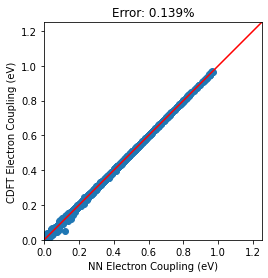

In [13]:
import matplotlib.pyplot as plt
# plotting
pred1 = NN.model(train_homo_pairs, training=False).numpy().reshape((len(train_homo_pairs),))
x = np.exp(-pred1) * 27.211
y1 = np.exp(-train_c_homo) * 27.211
y2 = train_c_lumo
x0 = [0,1.25]
y0 = [0,1.25]
fig, ax = plt.subplots()
ax.scatter(x,y1)
ax.plot(x0,y0, color='r')
ax.set_xlim(0,1.25)
ax.set_ylim(0,1.25)
ax.set_xlabel('NN Electron Coupling (eV)')
ax.set_ylabel('CDFT Electron Coupling (eV)')
ax.set_title('Error: %5.3f%%'%error1)
ax.set_aspect('equal')

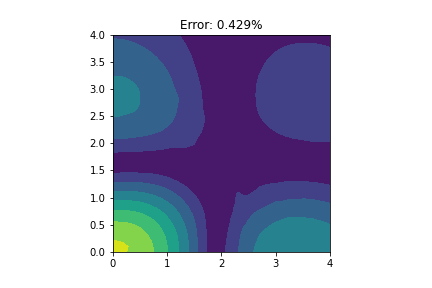

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib widget

error = np.mean(np.multiply(abs(NN.model(train_homo_pairs[0:1681], training=False).numpy().reshape((len(train_homo_pairs[0:1681]),))-train_c_homo[0:1681]), np.power(train_c_homo[0:1681],-1))*100)
x = np.linspace(0, 4, 41)
y = np.linspace(0, 4, 41)
Z = NN.model(train_homo_pairs[0:1681], training=False).numpy().reshape((41,41)).T
Z1 = c_homo[0:1681].reshape((41,41)).T

fix, ax = plt.subplots()
ax.contourf(x,y, np.exp(-Z))
ax.set_title('Error: %5.3f%%'%error)
ax.set_aspect('equal')
# plt.savefig('homo_pred.png')

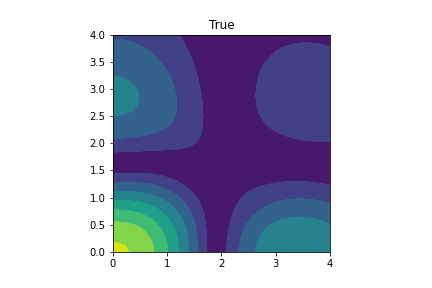

In [22]:
fix, ax = plt.subplots()
ax.contourf(x,y, Z1)
ax.set_title('True')
ax.set_aspect('equal')
# plt.savefig('homo_true.png')

481


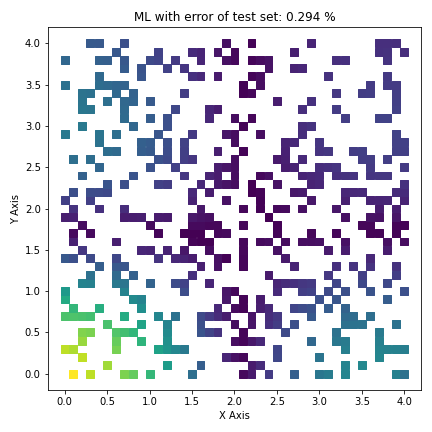

In [37]:
C = []
for i in x:
    for j in y:
        C_ = (i,j)
        C.append(C_)
C = np.array(C)
C_ = copy.deepcopy(C)
C = np.delete(C,index,0)
C__ = np.delete(C_,idiff,0)
print(len(C__))

Z = NN.model(test_homo, training=False).numpy()

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
ax.scatter(C__[:, 0], C__[:, 1], c=np.exp(-Z),s=62, marker=',')

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')

error = np.mean(np.multiply(NN.model(test_homo, training=False).numpy().reshape((len(test_homo),))-test_chomo, np.power(test_chomo,-1))*100)
plt.title('ML with error of test set: %5.3f %%'%error)
plt.tight_layout()
plt.show()

# plt.savefig('test.jpg')

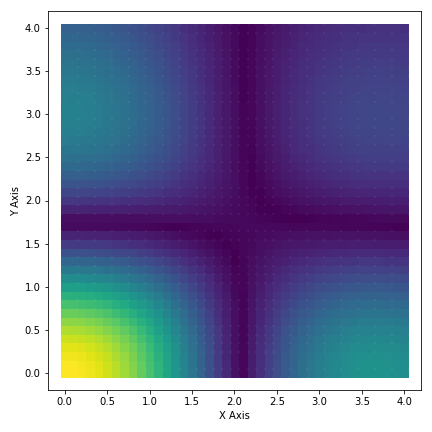

In [38]:
Z1 = train_chomo
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
ax.scatter(C_[:, 0], C_[:, 1], c=np.exp(-Z1),s=62, marker=',')

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')

# plt.title('HOMO of Naphthalene')
plt.tight_layout()
plt.show()
# plt.savefig('test.jpg')

In [23]:
NN.model.summary()

Model: "private_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           multiple                  0         
                                                                 
 flatten_1 (Flatten)         multiple                  0         
                                                                 
 concatenate (Concatenate)   multiple                  0         
                                                                 
 batch_normalization (BatchN  multiple                 1024      
 ormalization)                                                   
                                                                 
 batch_normalization_1 (Batc  multiple                 1024      
 hNormalization)                                                 
                                                                 
 batch_normalization_2 (Batc  multiple                 

In [23]:
from gpr_frame import GPR
# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.gaussian_process.kernels import RBF
# from sklearn.metrics import mean_squared_error as mse
# from sklearn.metrics import mean_absolute_error as mae

# class GPR():
#     def __init__(self, json_path=None, setting_dict=None):
#         setting_ = {'alpha':1, 'kernel':'RBF', 'optimizer':'fmin_l_bfgs_b', 'length_scale':1.0, 'length_scale_bounds':(1e-2, 1e2)}  # default setting   
#         if json_path is not None:
#             setting = json.load(json_path)
#         elif (json_path is None) and (setting_dict is not None):
#             setting = setting_dict
#         else:
#             print('No setting is specified, default setting will be applied.')
#             setting = setting_
#         self.setting = setting

#         if self.setting['kernel'] == 'RBF':
#             self.kernel = RBF(length_scale=self.setting['length_scale'], length_scale_bounds=self.setting['length_scale_bounds'])
        
#         self.alpha = self.setting['alpha']

#     def train(self, X, Y):
#         self.model = GaussianProcessRegressor(kernel=self.kernel, alpha=self.alpha)
#         self.model.fit(X, Y)

#     def predict(self, X):
#         x_pred, std_pred = self.model.predict(X, return_std=True)
#         return x_pred, std_pred
    
gpr = GPR(setting_dict={'alpha':0.01, 'kernel':'RBF', 'optimizer':'fmin_l_bfgs_b', 'length_scale':0.1, 'length_scale_bounds':(1e-2, 1e1)})
dshape = train_homo_.shape
new_train = train_homo_.reshape((dshape[0],dshape[1]*dshape[2]*dshape[3]))
print(new_train.shape)
gpr.train(new_train, train_chomo_)

(15129, 128)


In [24]:
pred1, std1 = gpr.predict(train_homo_pairs.reshape((len(train_homo_pairs),2*8*8)))
pred2, std2 = gpr.predict(train_homo_.reshape((len(train_homo_),2*8*8)))
pred3, std3 = gpr.predict(test_homo.reshape((len(test_homo),2*8*8)))

In [25]:
error1 = np.mean(np.multiply(pred1-train_c_homo, np.power(train_c_homo,-1))*100)
error2 = np.mean(np.multiply(pred2-train_chomo_, np.power(train_chomo_,-1))*100)
error3 = np.mean(np.multiply(pred3-test_chomo, np.power(test_chomo,-1))*100)
print('Error of full data set: %5.3f %% \nError of training set with %d samples: %5.3f %% \nError of testing set with %d samples: %5.3f %% '%(error1,len(train_homo_),error2,len(test_homo),error3))

Error of full data set: -0.150 % 
Error of training set with 15129 samples: -0.021 % 
Error of testing set with 35301 samples: -0.205 % 


In [26]:
error1 = np.mean(np.multiply(abs(pred1-train_c_homo), np.power(train_c_homo,-1))*100)
error2 = np.mean(np.multiply(abs(pred2-train_chomo_), np.power(train_chomo_,-1))*100)
error3 = np.mean(np.multiply(abs(pred3-test_chomo), np.power(test_chomo,-1))*100)
print('Error of full data set: %5.3f %% \nError of training set with %d samples: %5.3f %% \nError of testing set with %d samples: %5.3f %% '%(error1,len(train_homo_),error2,len(test_homo),error3))

Error of full data set: 1.591 % 
Error of training set with 15129 samples: 0.721 % 
Error of testing set with 35301 samples: 1.964 % 


In [ ]:
# plotting
x = np.exp(-pred1) * 27.211
y1 = np.exp(-train_c_homo) * 27.211
y2 = train_c_lumo
x0 = [0,1.25]
y0 = [0,1.25]
fig, ax = plt.subplots()
ax.scatter(x,y1)
ax.plot(x0,y0, color='r')
ax.set_xlim(0,1.25)
ax.set_ylim(0,1.25)
ax.set_xlabel('GPR Electron Coupling (eV)')
ax.set_ylabel('CDFT Electron Coupling (eV)')
# ax.set_title('Error: %5.3f%%'%error)
ax.set_aspect('equal')

In [ ]:
C = []
for i in x:
    for j in y:
        C_ = (i,j)
        C.append(C_)
C = np.array(C)
C_ = copy.deepcopy(C)
C = np.deleteete(C_,idiff,0)(C,index,0)
C__ = np.del
print(len(C__))
pred, std = gpr.predict(test_homo.reshape((481,2*8*8)))
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot()
ax.scatter(C__[:, 0], C__[:, 1], c=np.exp(-pred),s=40, marker=',')

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 6)

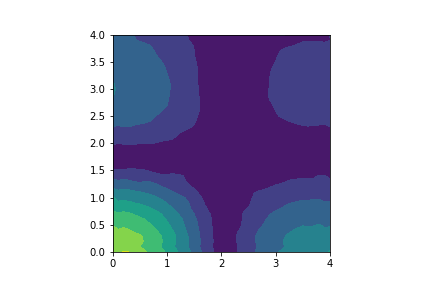

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib widget

# error = np.mean(np.multiply(NN.model(train_homo_pairs, training=False).numpy().reshape((len(train_homo_pairs),))-train_c_homo, np.power(train_c_homo,-1))*100)
x = np.linspace(0, 4, 41)
y = np.linspace(0, 4, 41)
# Z = NN.model(train_homo_pairs, training=False).numpy().reshape((41,41)).T
pred, std = gpr.predict(train_homo_pairs.reshape((1681,2*8*8)))
Z = pred.reshape((41,41)).T
Z1 = c_homo.reshape((41,41)).T

fix, ax = plt.subplots()
ax.contourf(x,y, np.exp(-Z))
# ax.set_title('Error: %5.3f%%'%error)
ax.set_aspect('equal')

# plt.savefig('homo_pred.png')